# Millikan Oil Drop Analysis

### Kristen Sullivan, Ben Montgomery, Sunny Pinkham 

In [1]:
import os
import numpy as np
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from miltools import *

Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df14\track0.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df14\track1.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df13\track1.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df13\track2.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df12\track0.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df11\track0.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df11\track1.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df11\track2.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df11\track3.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df9\track0.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectories\df8\track0.csv
Opening  C:\Users\Ben\Dropbox\Documents\PHY240\millikan\Trajectorie

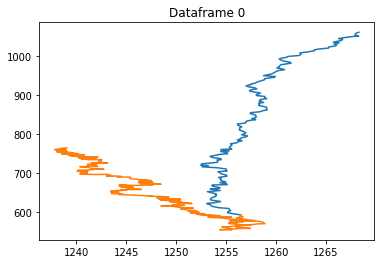

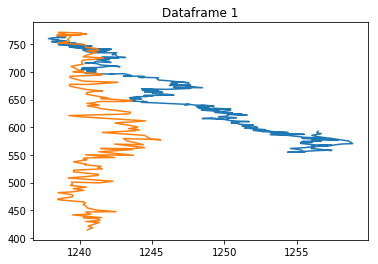

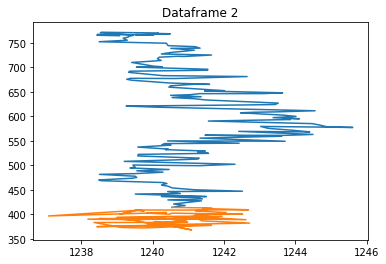

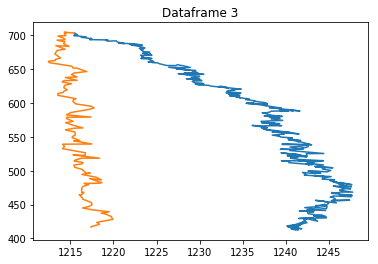

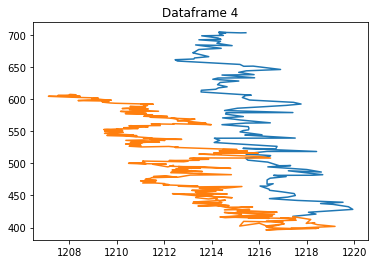

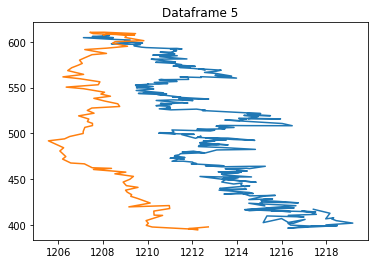

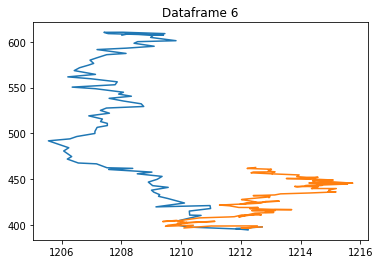

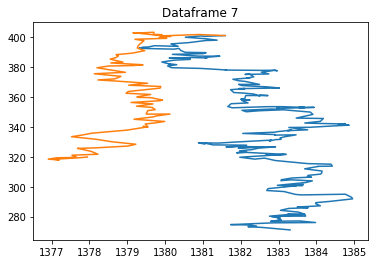

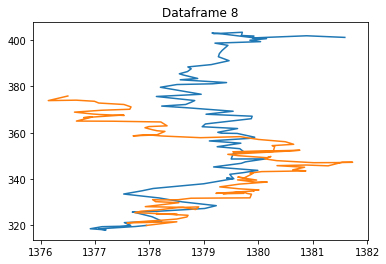

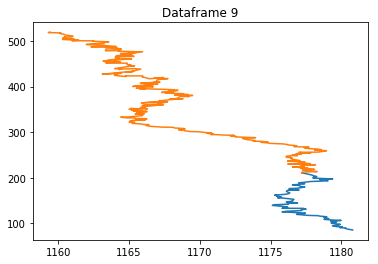

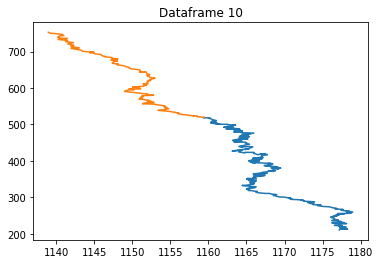

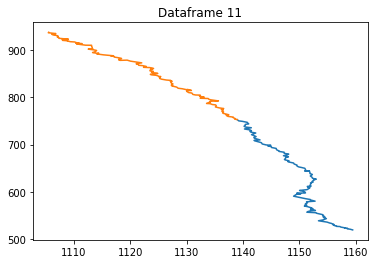

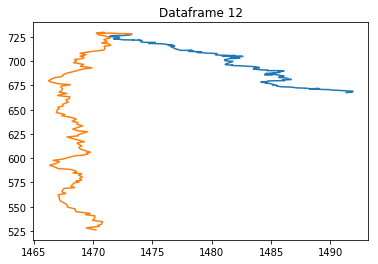

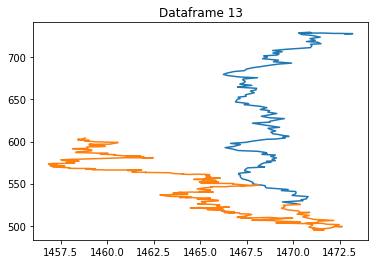

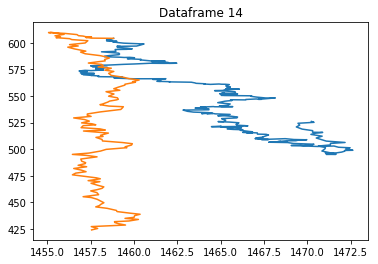

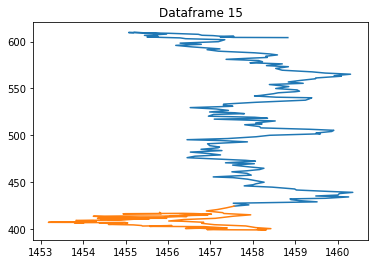

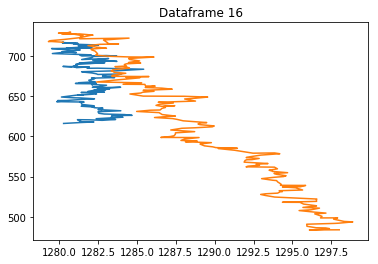

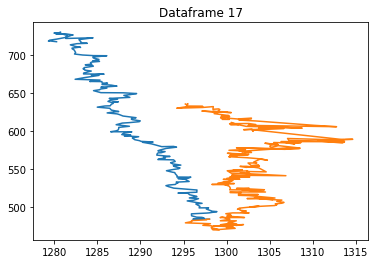

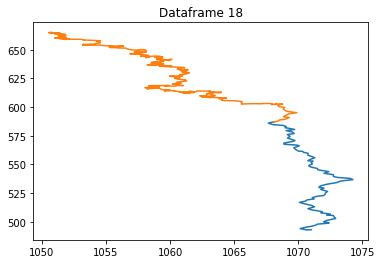

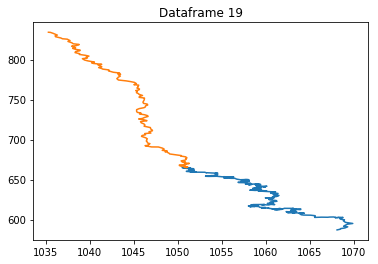

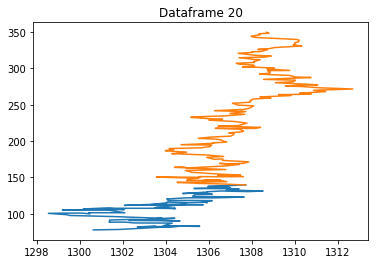

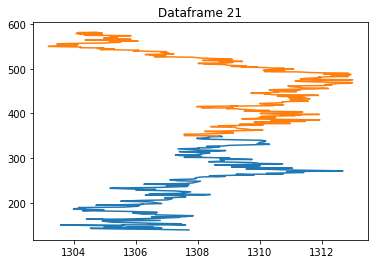

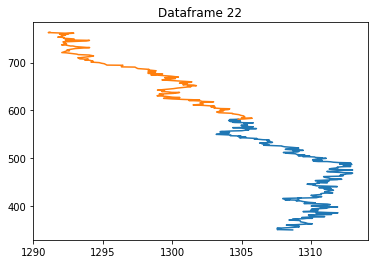

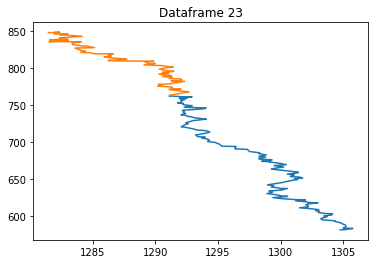

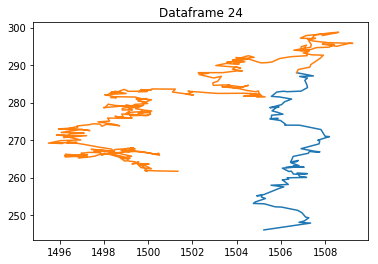

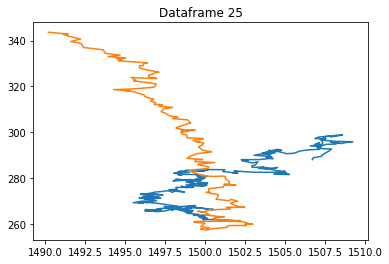

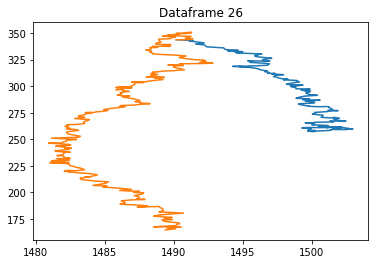

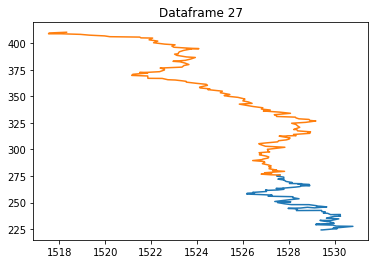

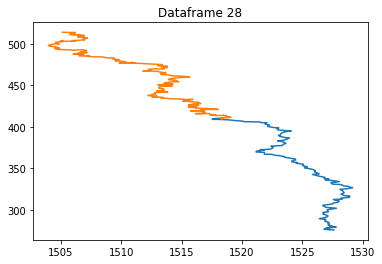

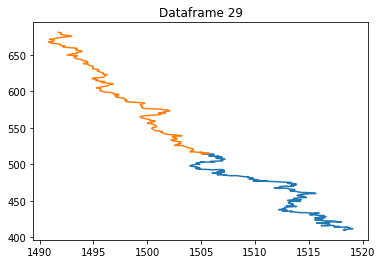

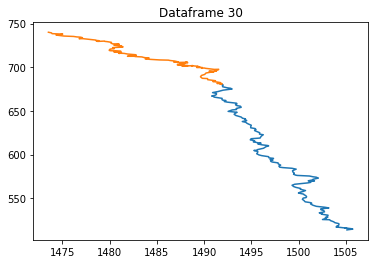

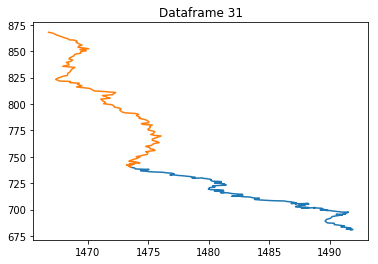

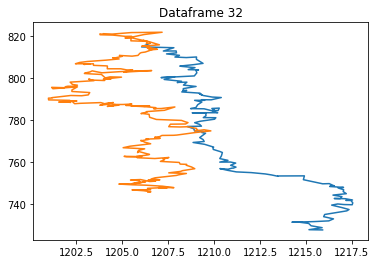

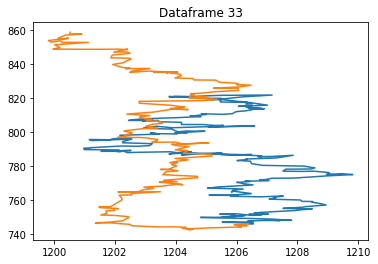

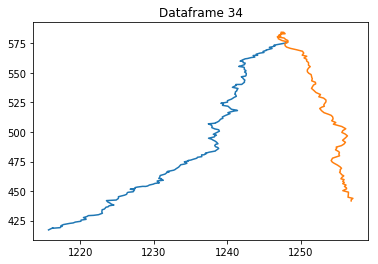

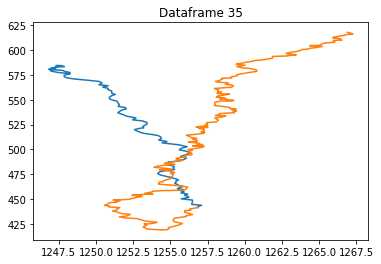

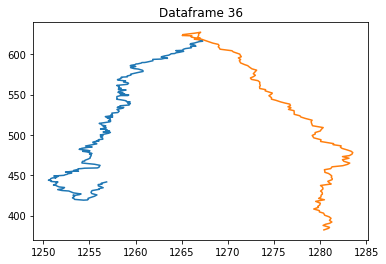

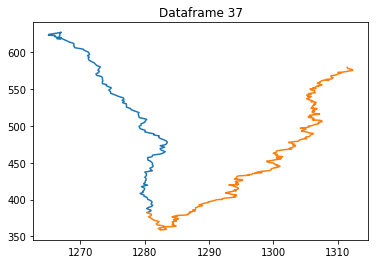

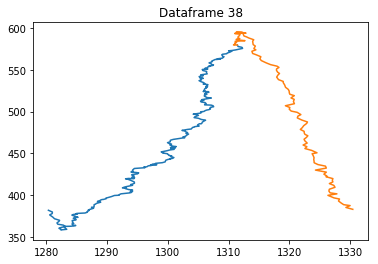

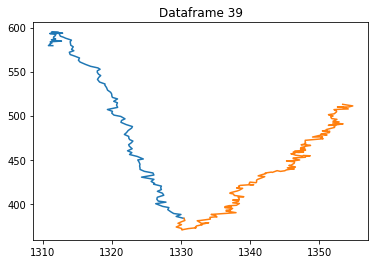

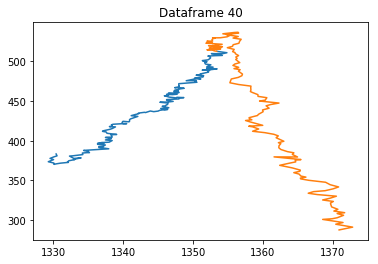

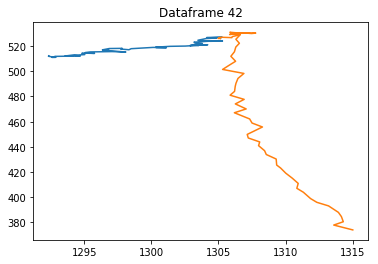

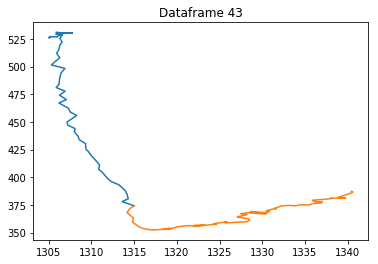

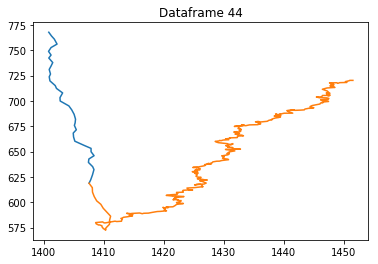

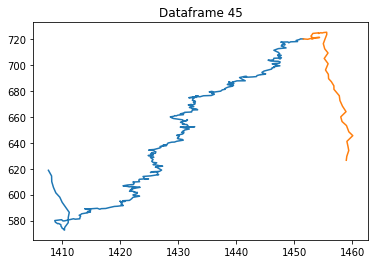

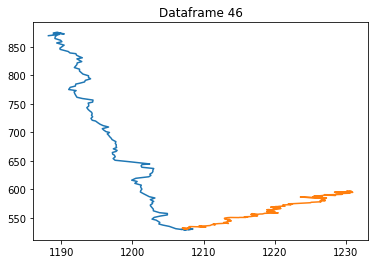

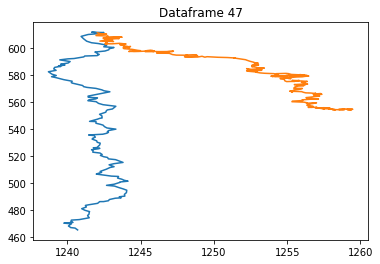

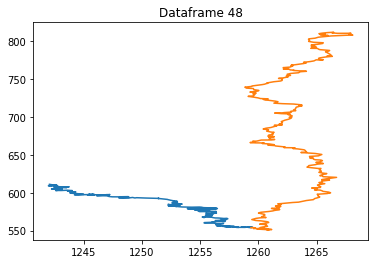

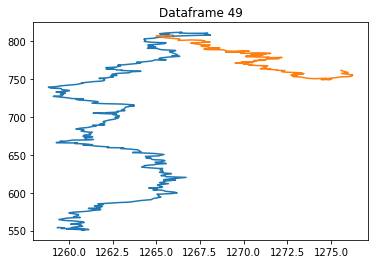

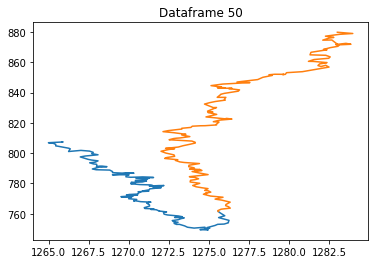

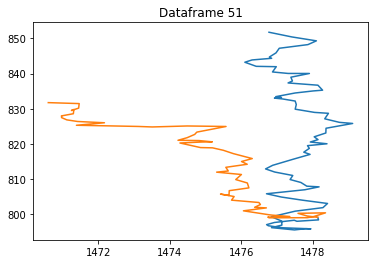

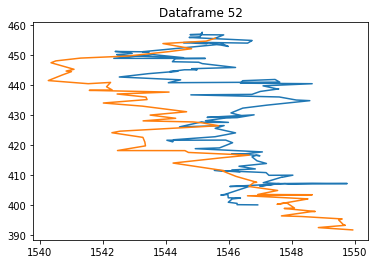

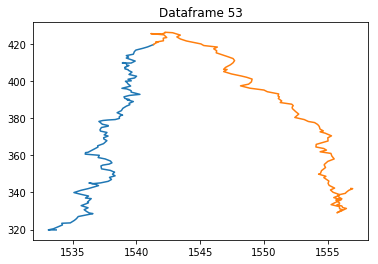

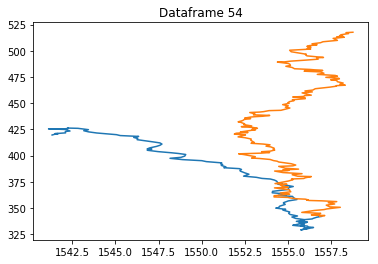

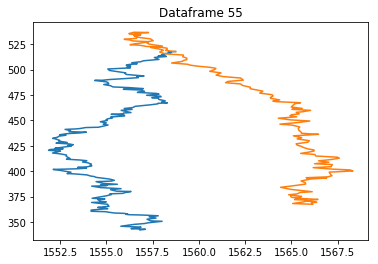

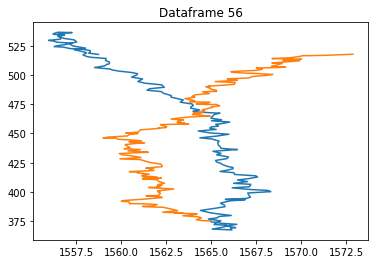

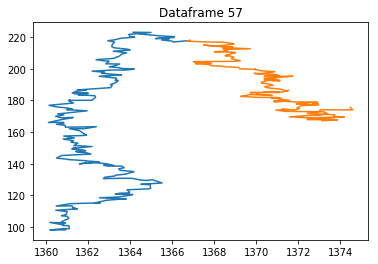

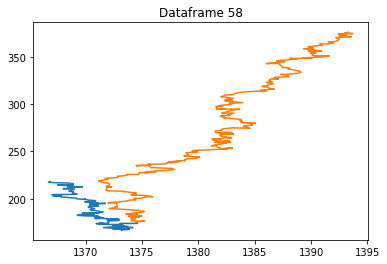

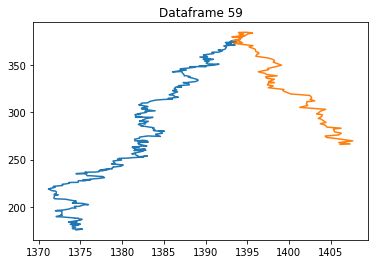

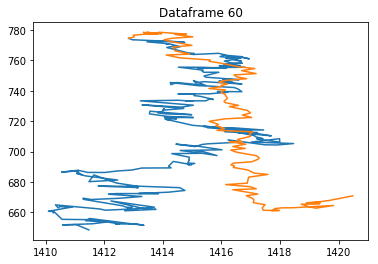

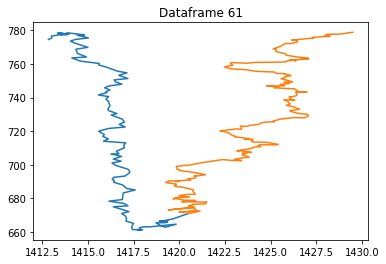

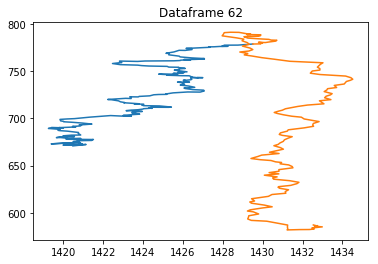

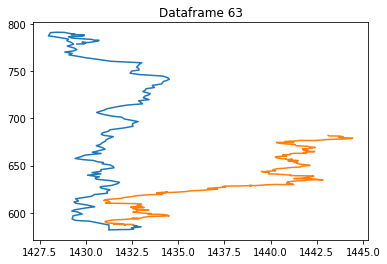

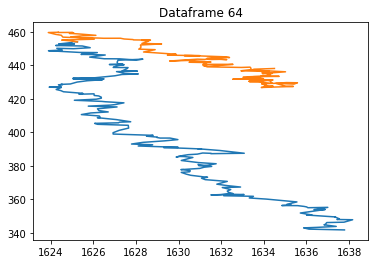

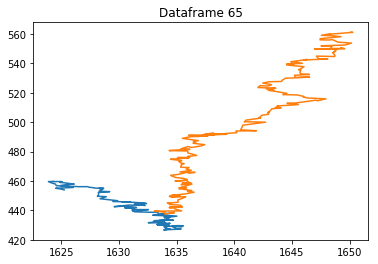

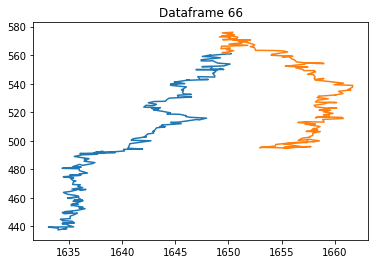

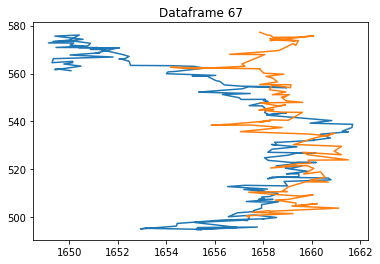

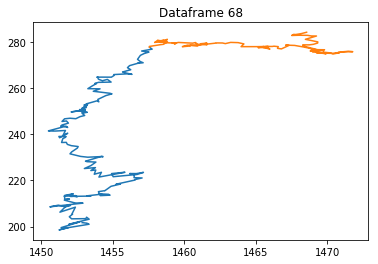

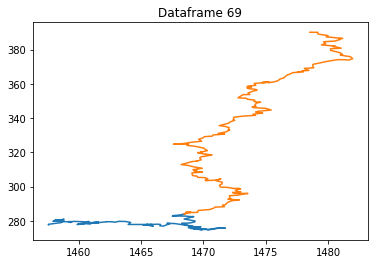

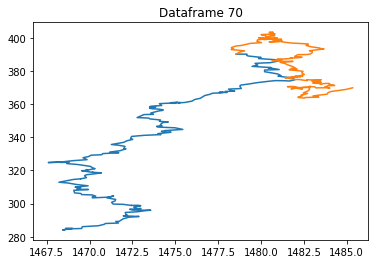

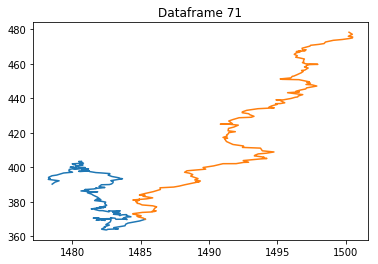

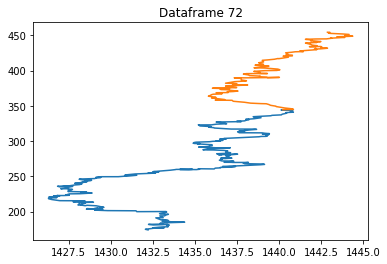

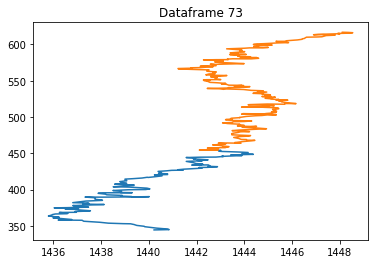

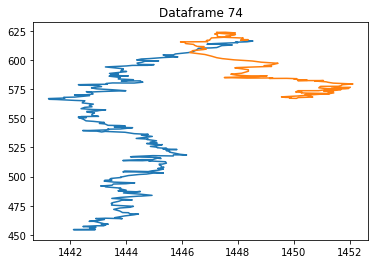

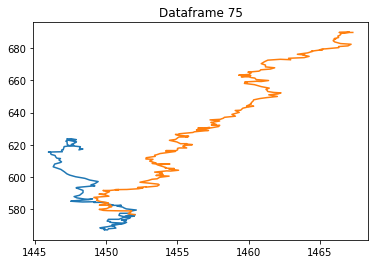

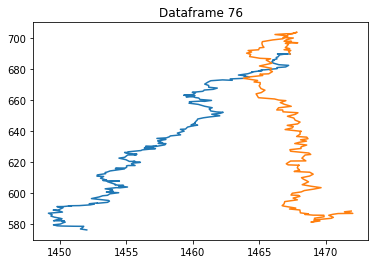

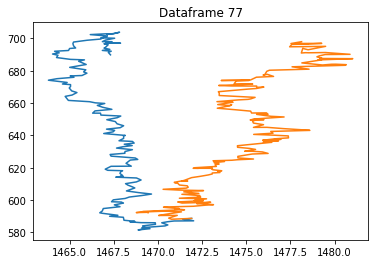

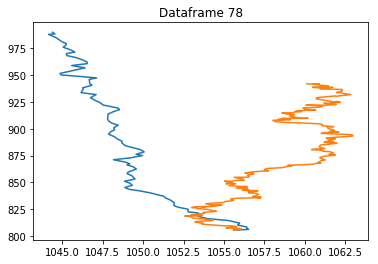

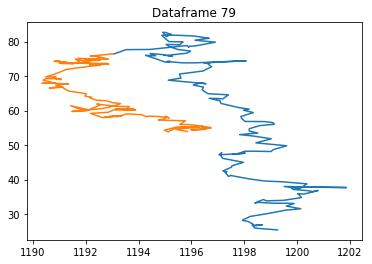

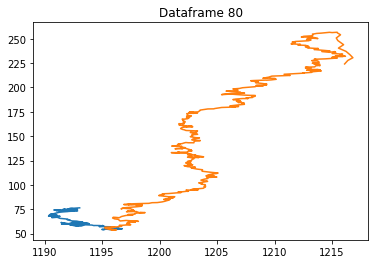

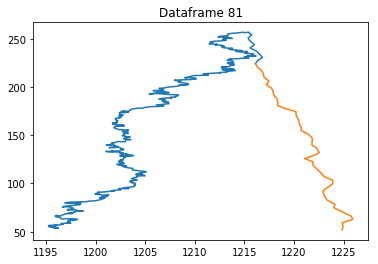

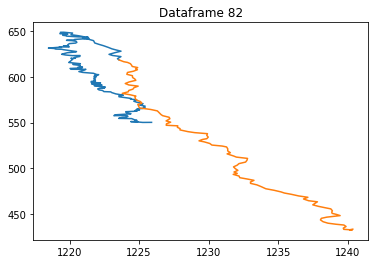

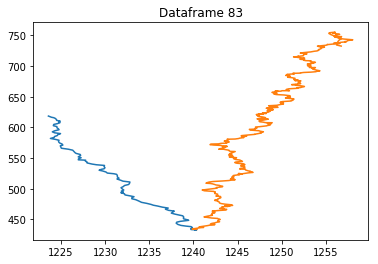

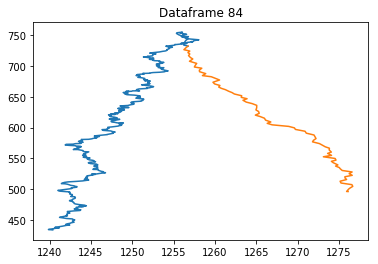

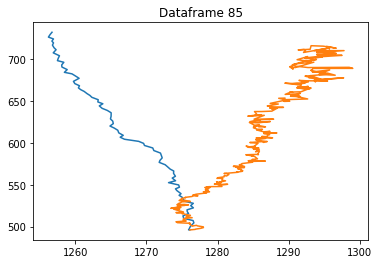

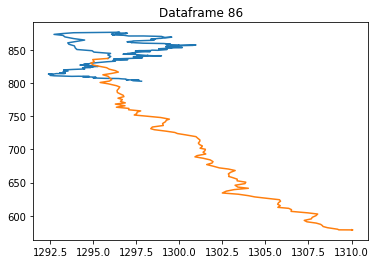

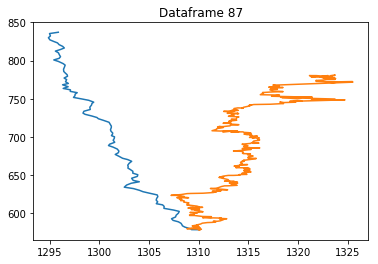

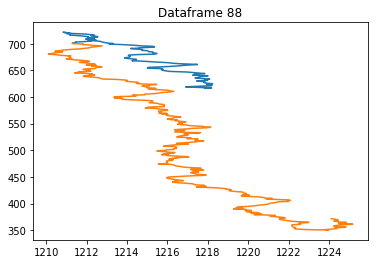

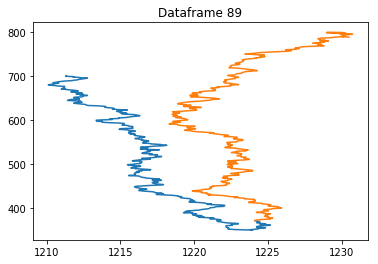

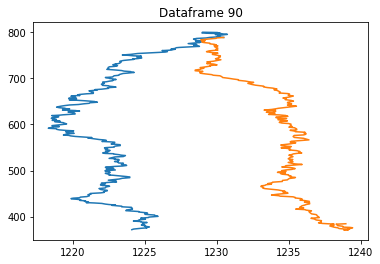

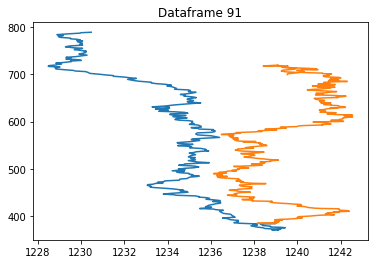

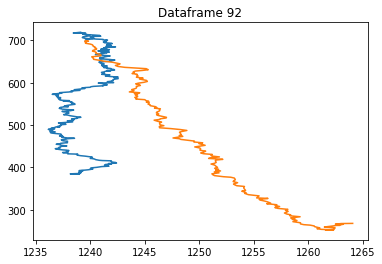

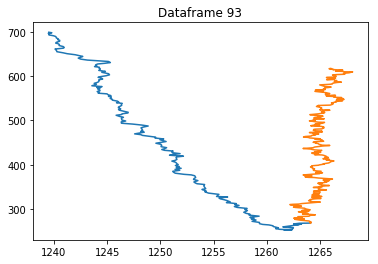

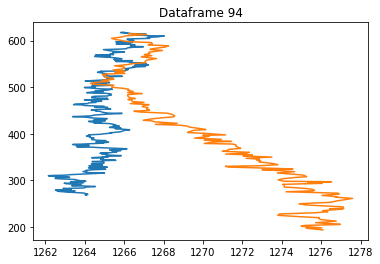

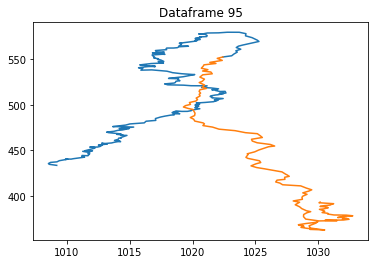

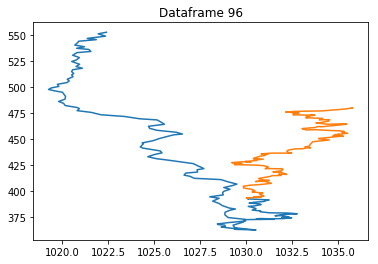

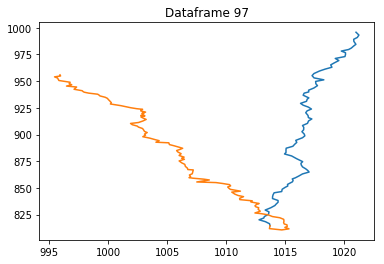

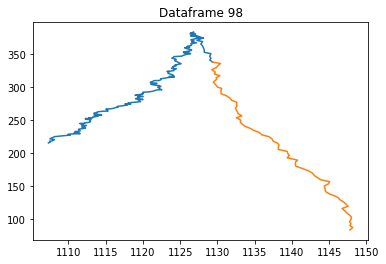

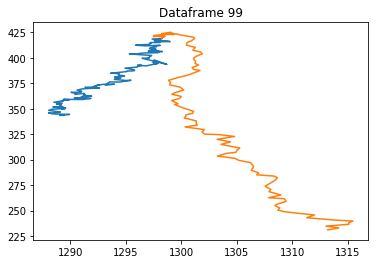

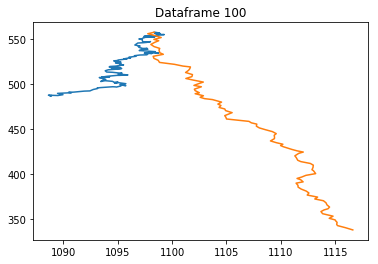

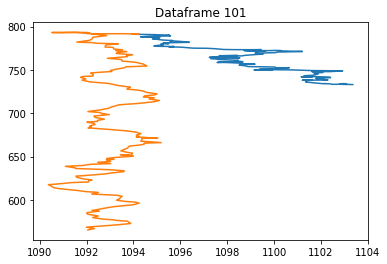

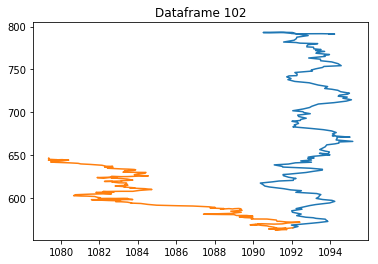

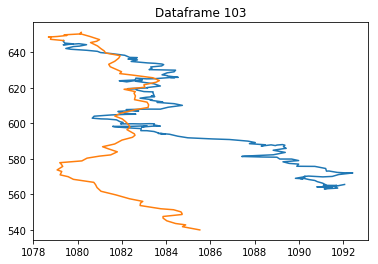

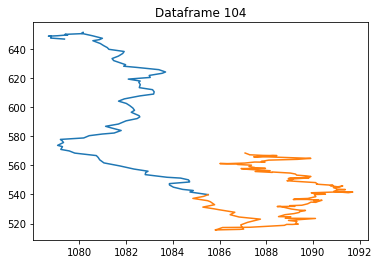

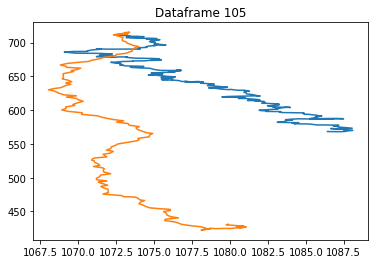

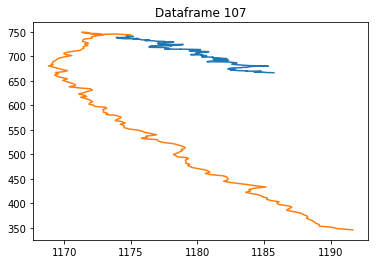

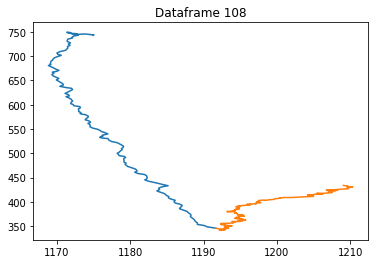

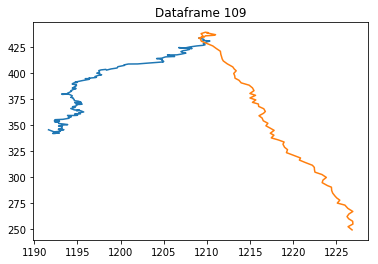

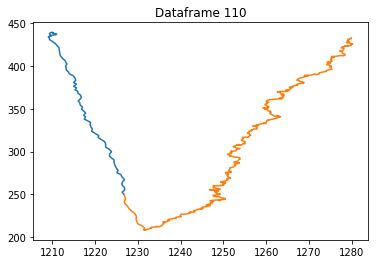

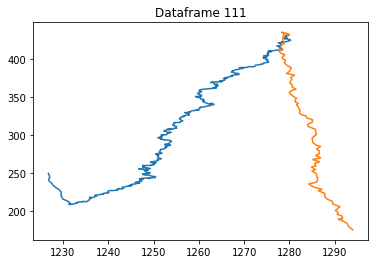

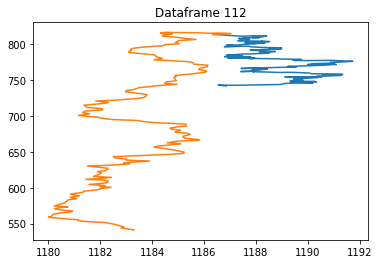

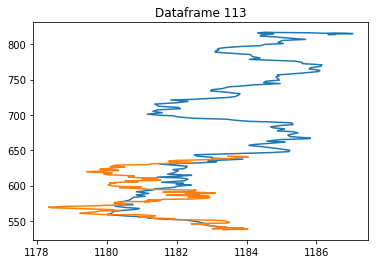

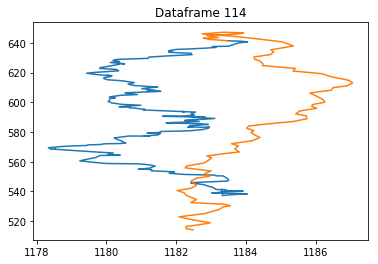

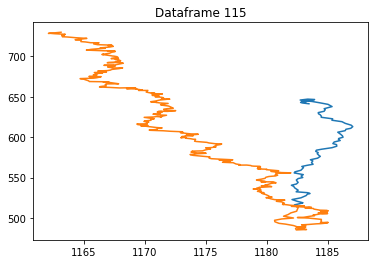

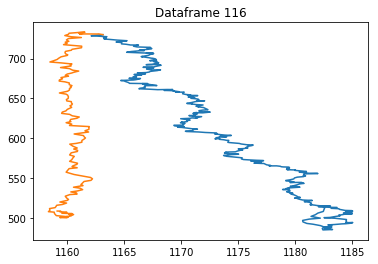

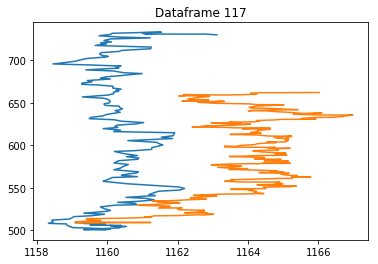

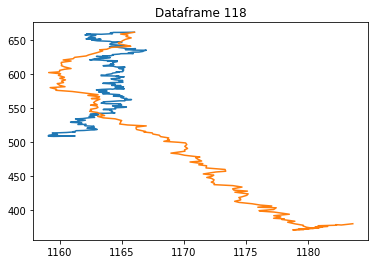

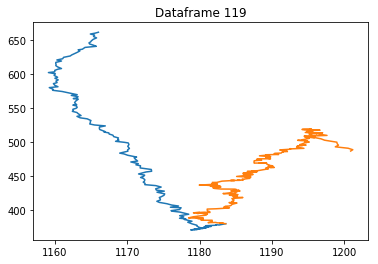

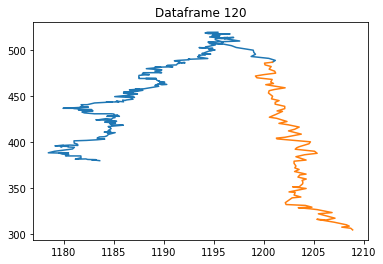

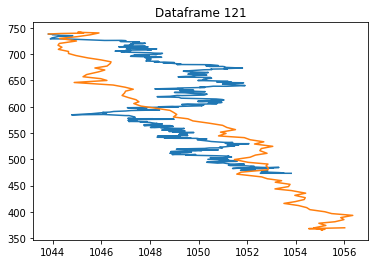

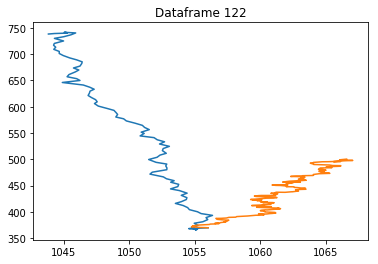

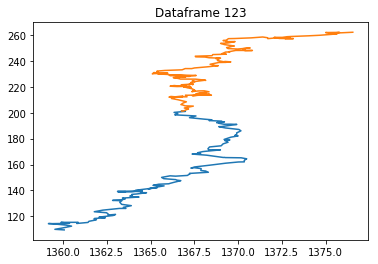

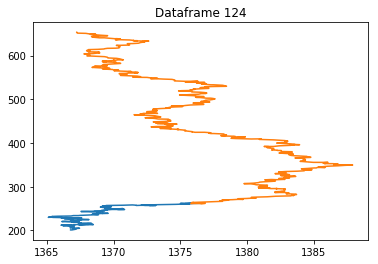

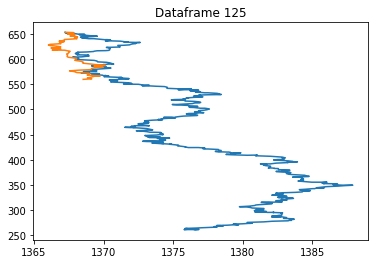

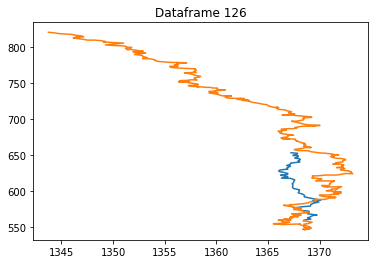

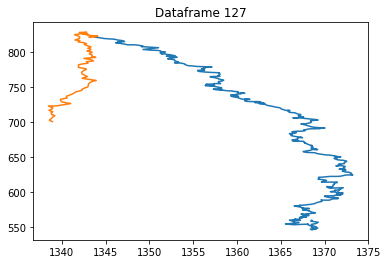

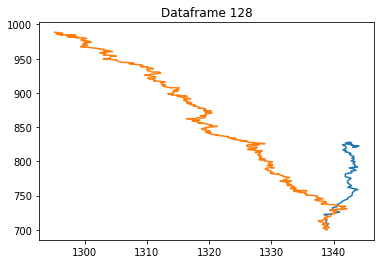

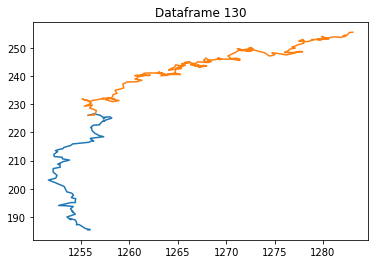

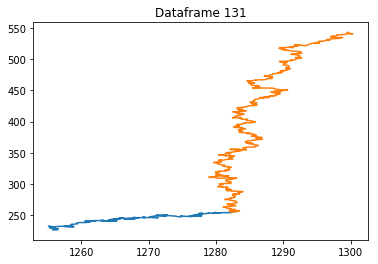

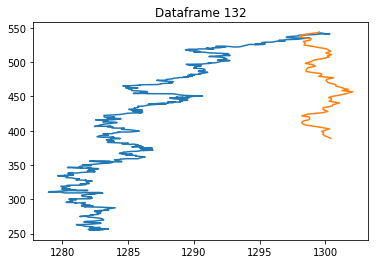

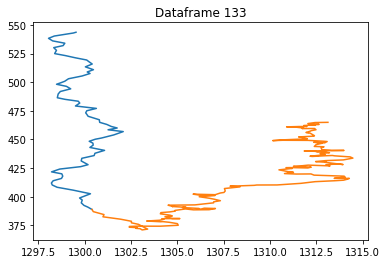

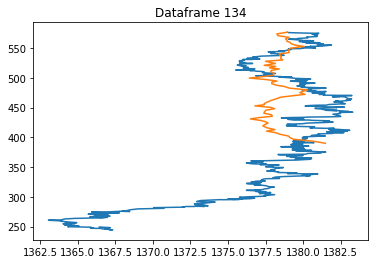

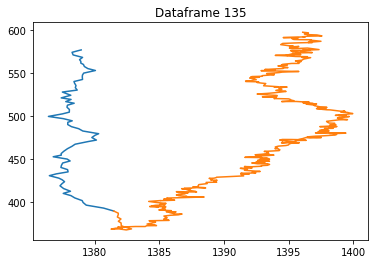

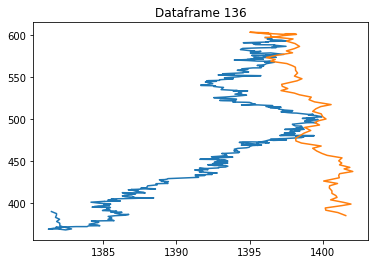

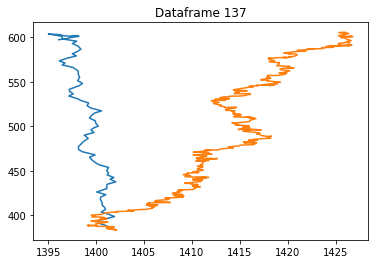

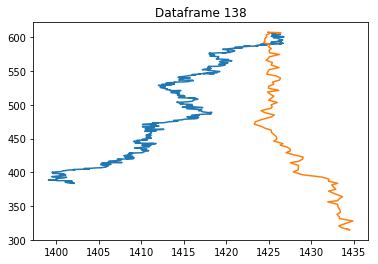

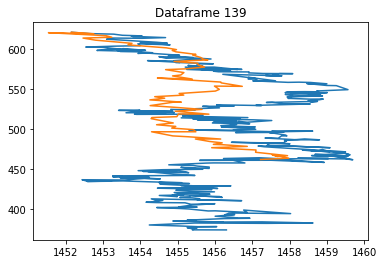

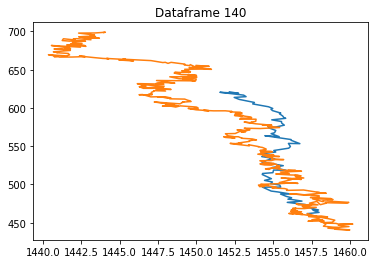

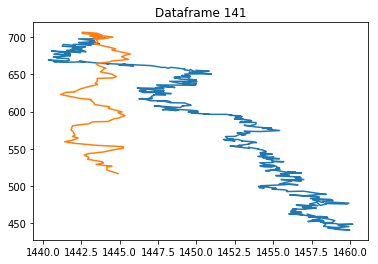

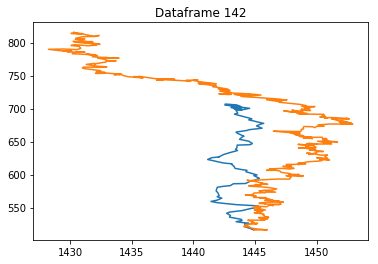

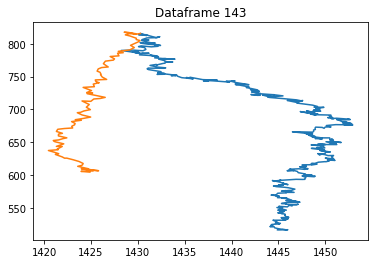

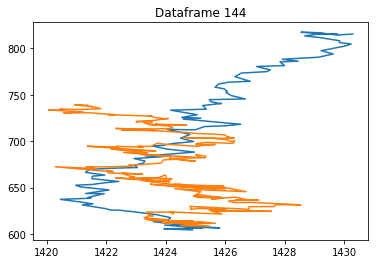

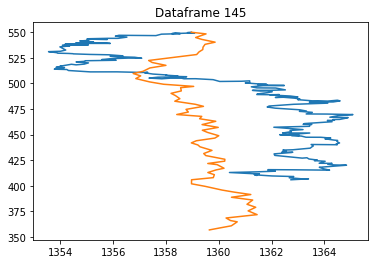

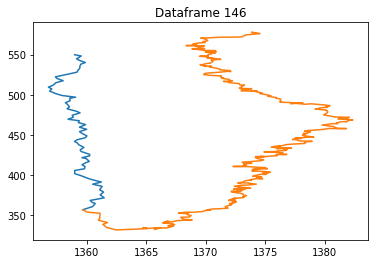

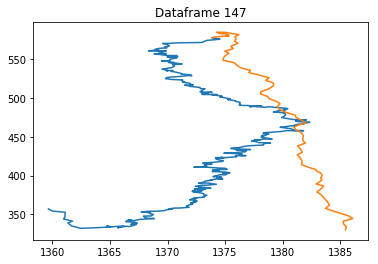

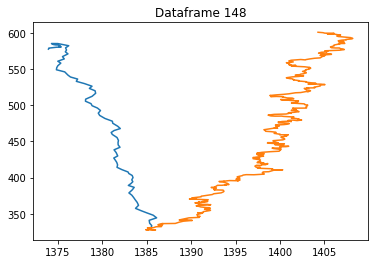

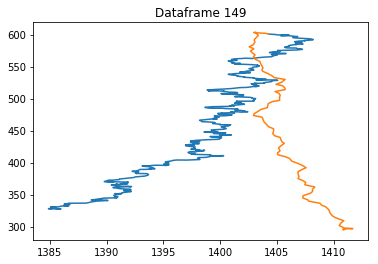

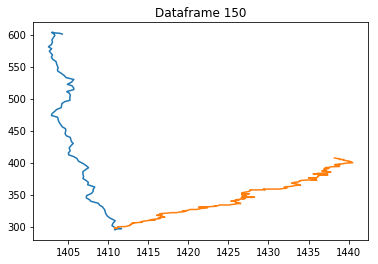

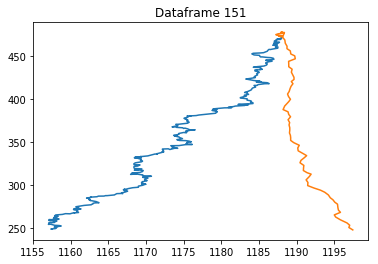

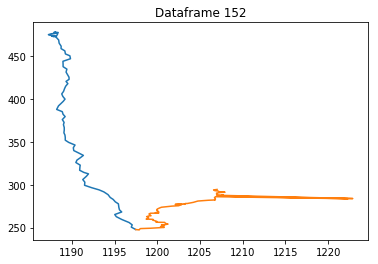

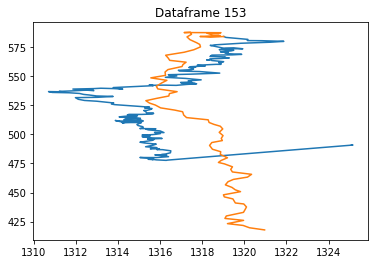

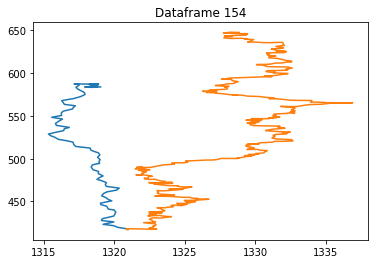

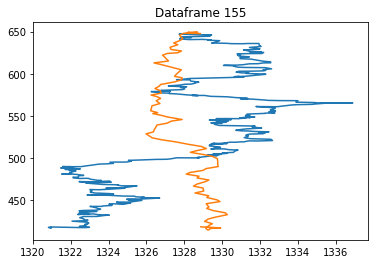

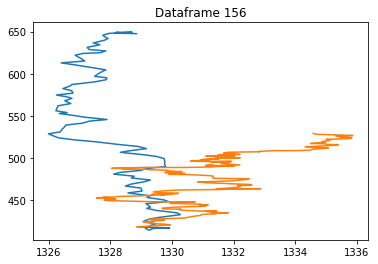

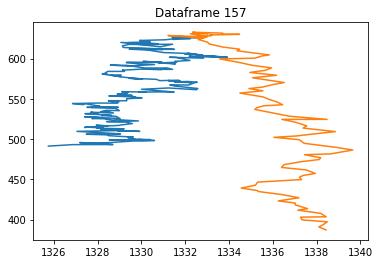

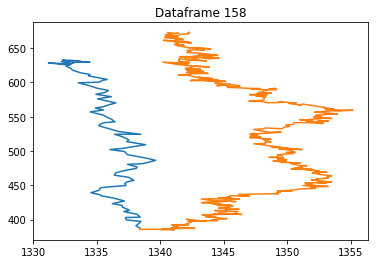

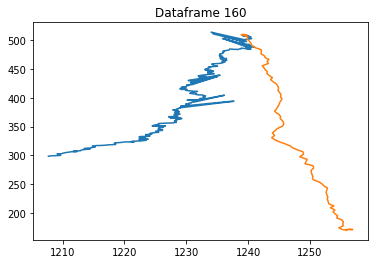

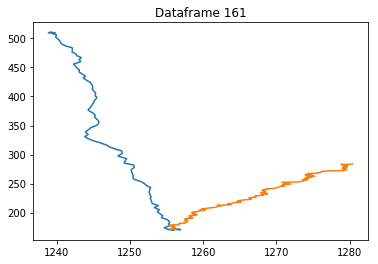

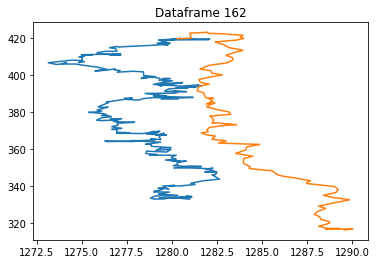

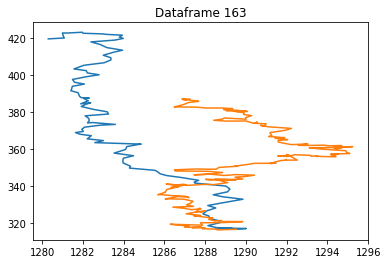

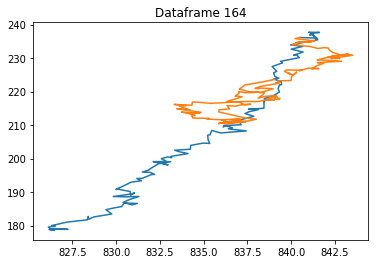

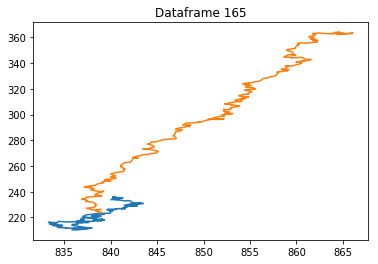

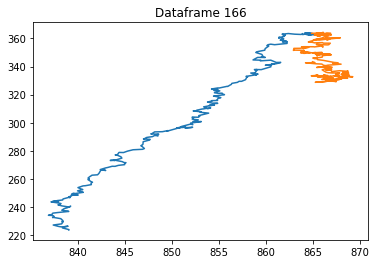

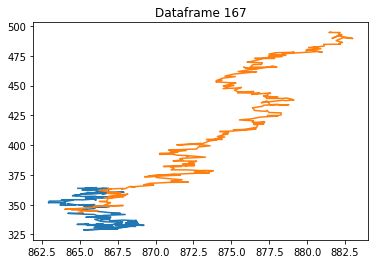

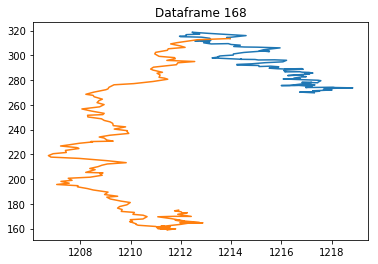

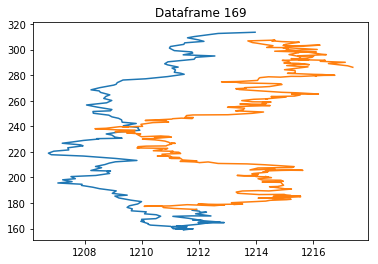

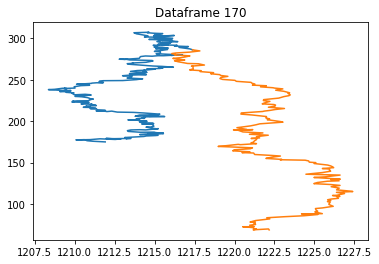

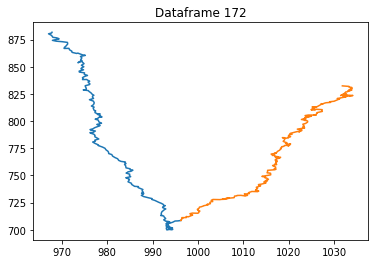

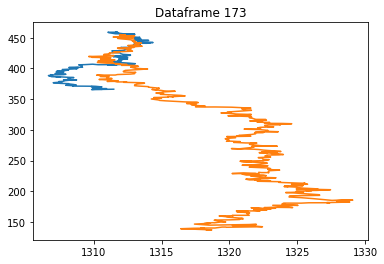

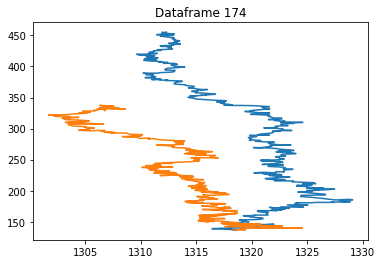

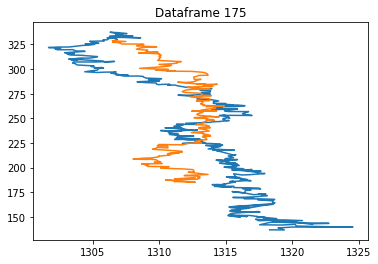

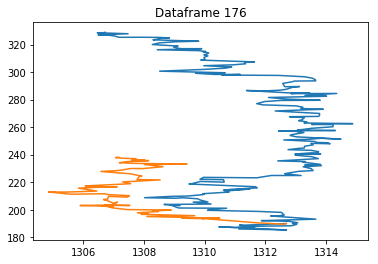

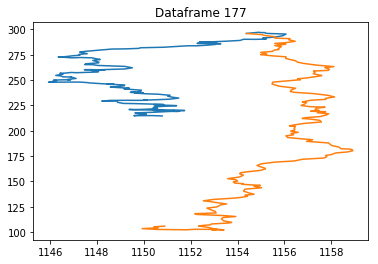

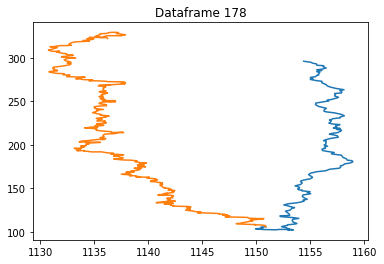

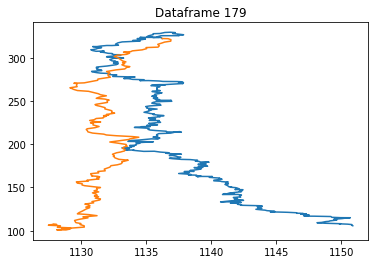

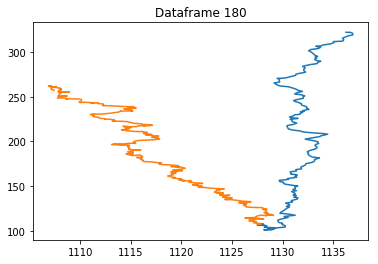

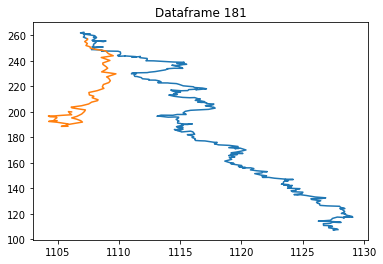

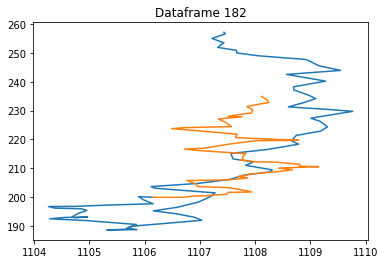

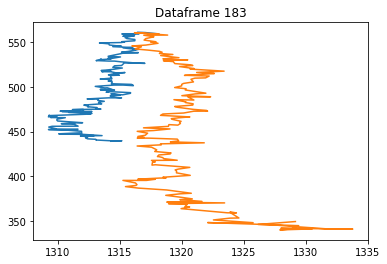

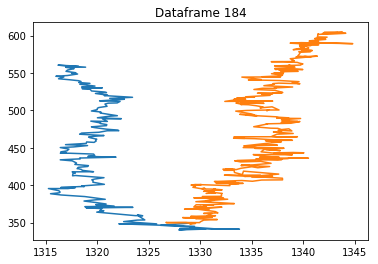

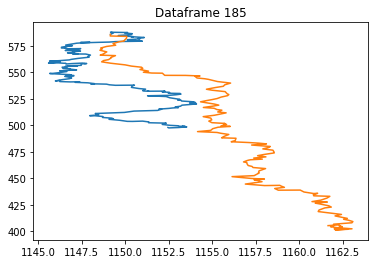

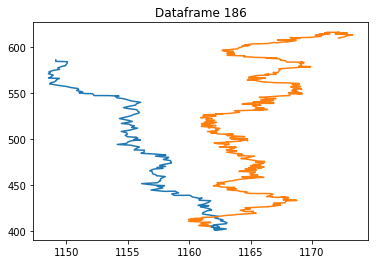

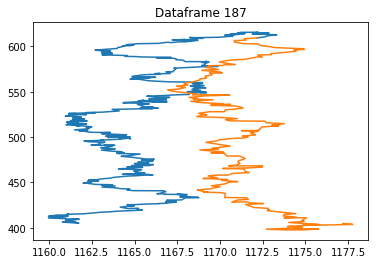

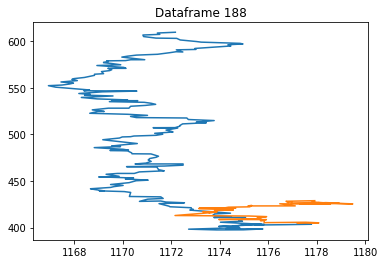

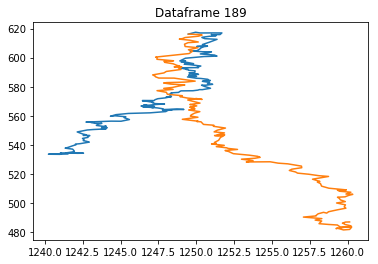

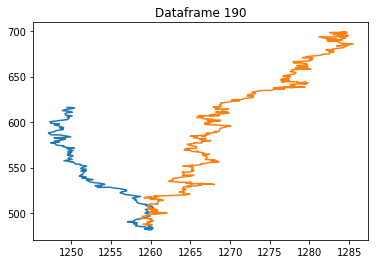

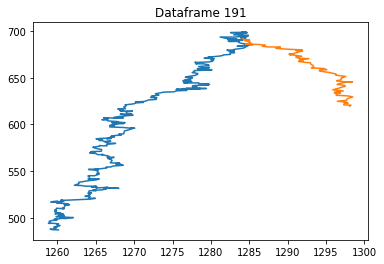

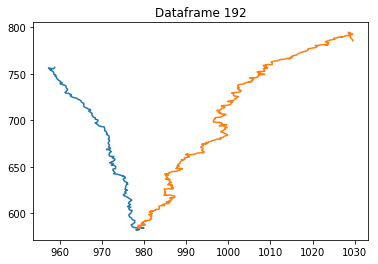

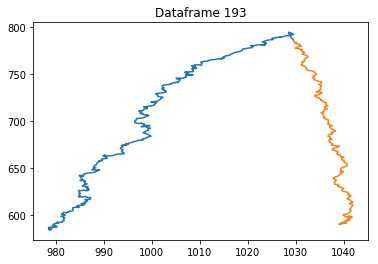

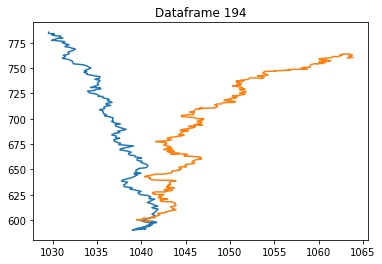

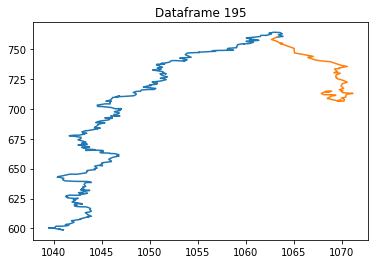

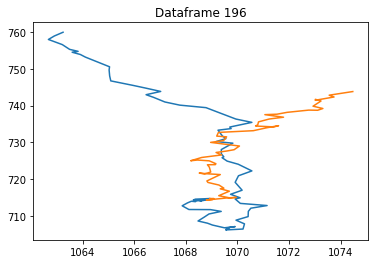

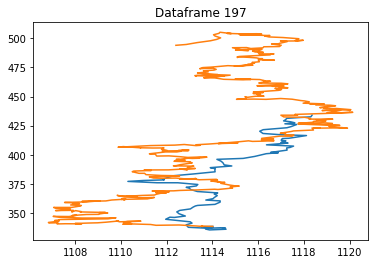

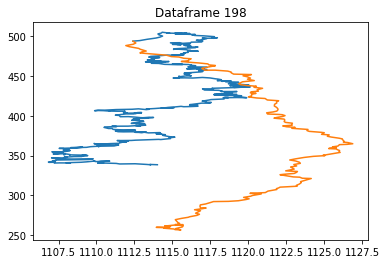

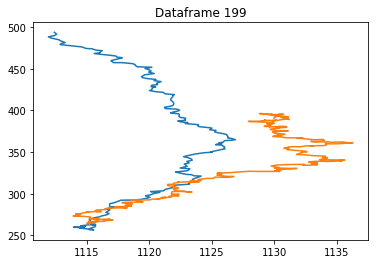

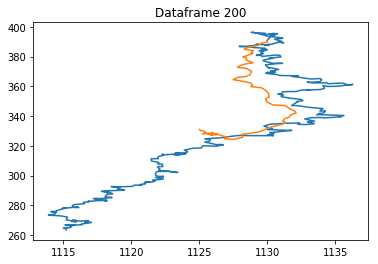

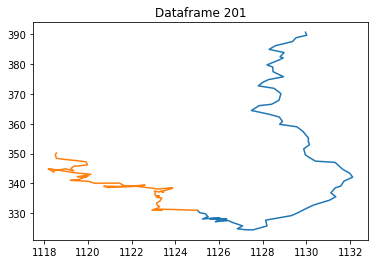

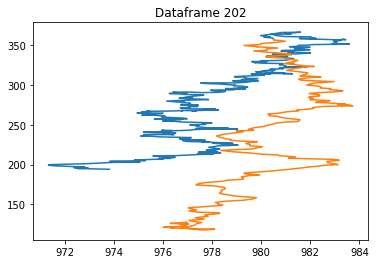

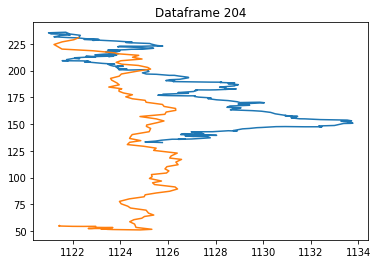

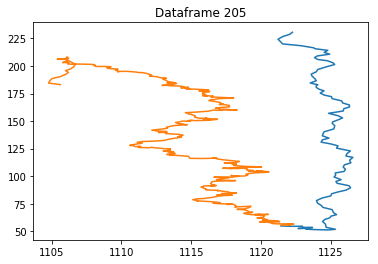

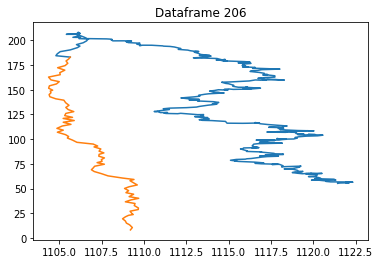

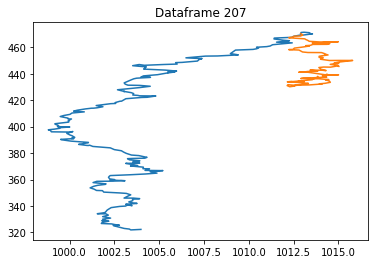

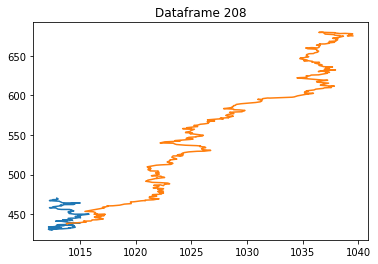

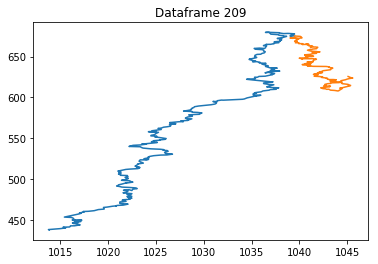

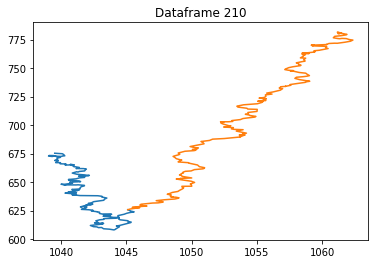

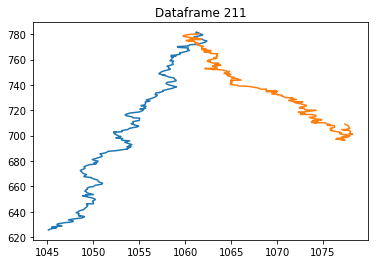

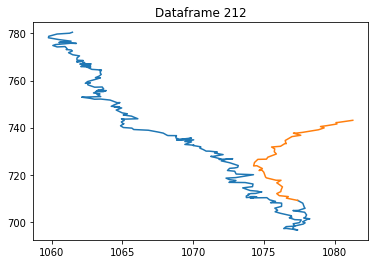

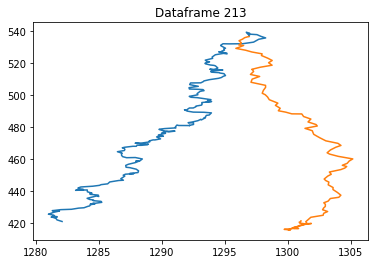

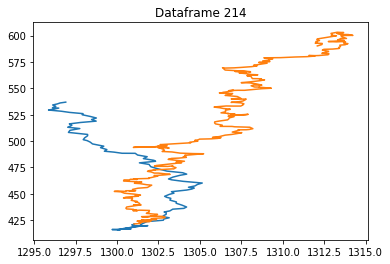

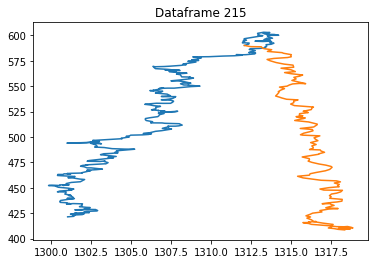

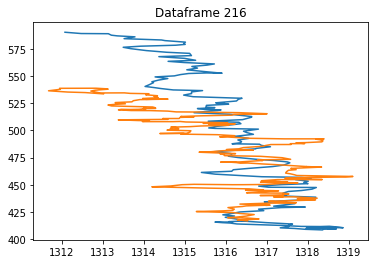

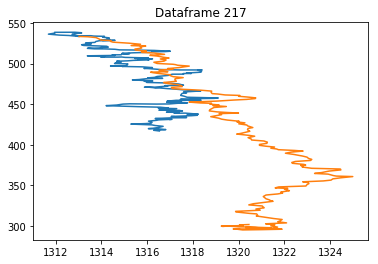

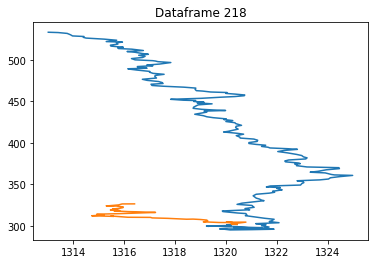

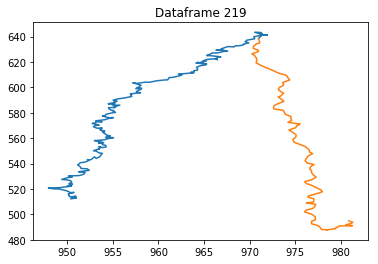

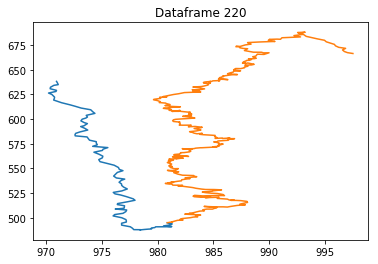

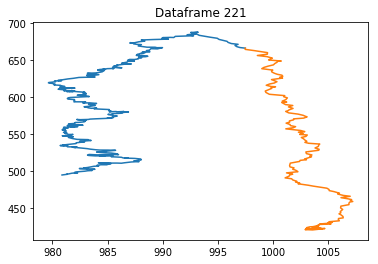

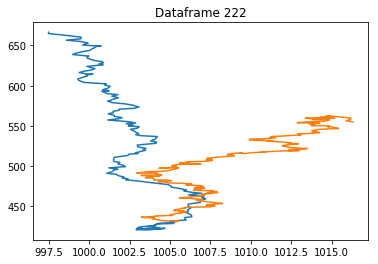

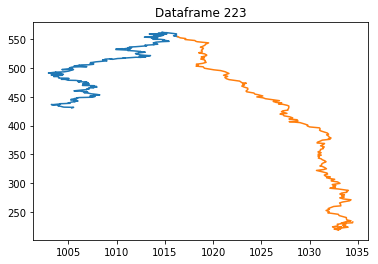

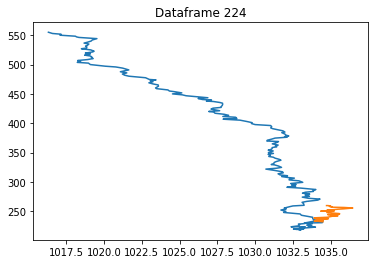

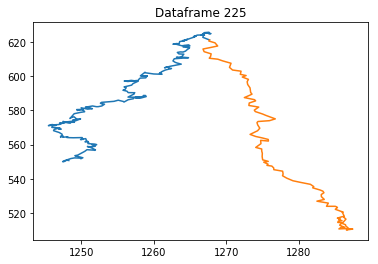

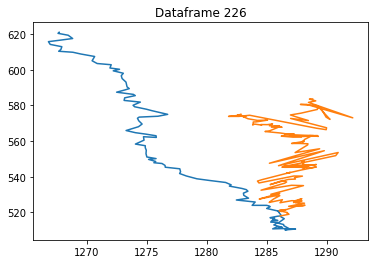

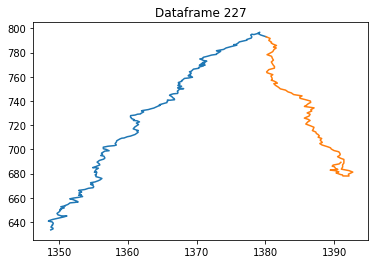

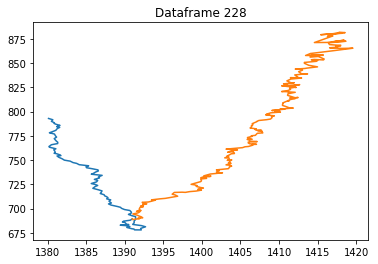

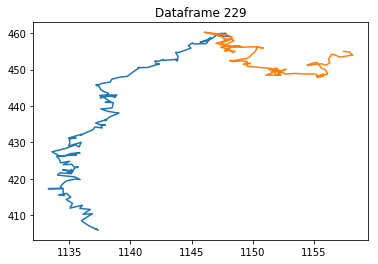

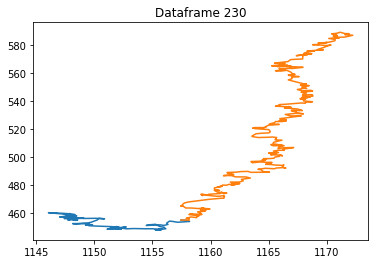

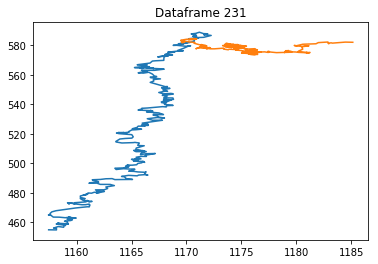

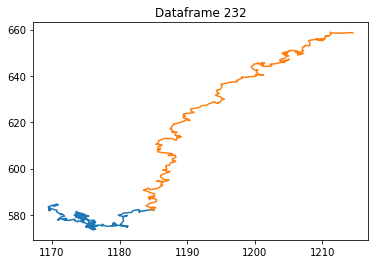

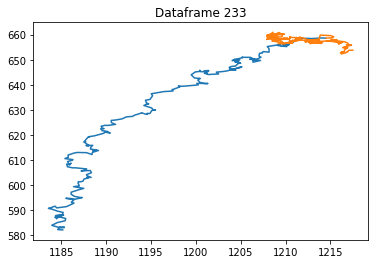

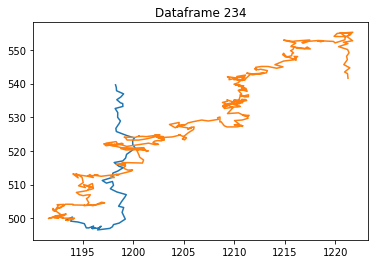

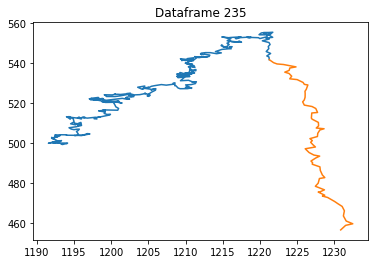

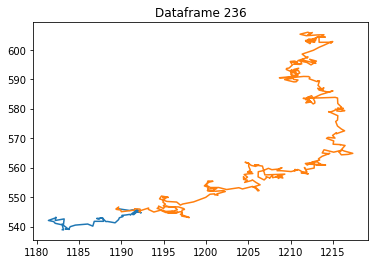

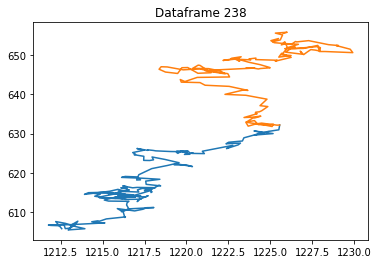

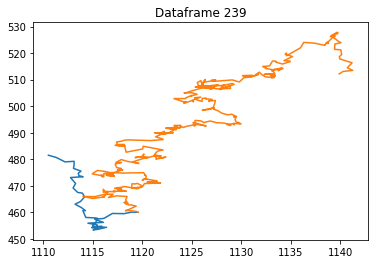

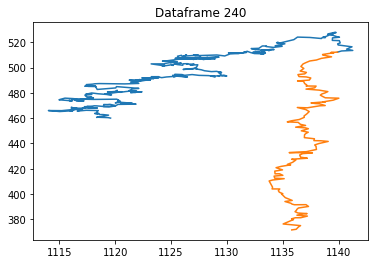

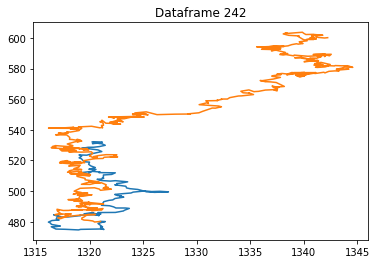

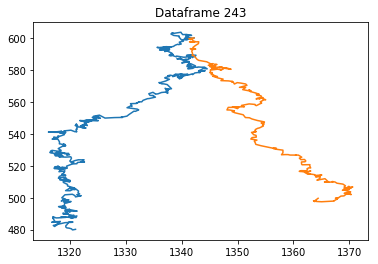

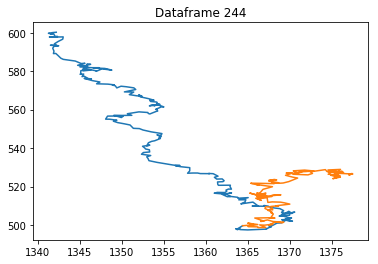

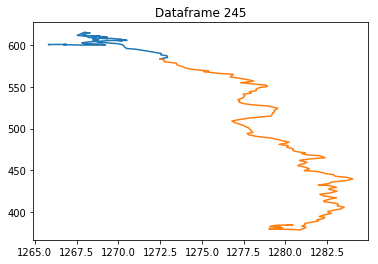

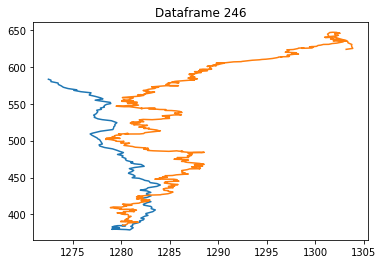

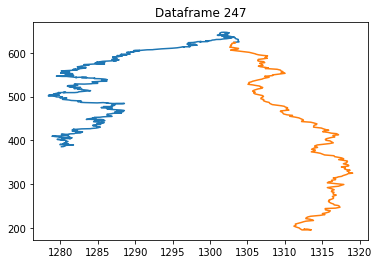

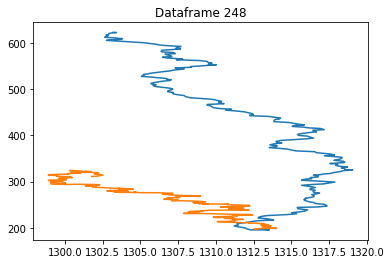

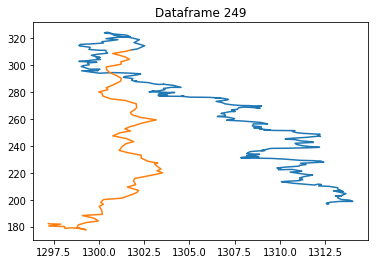

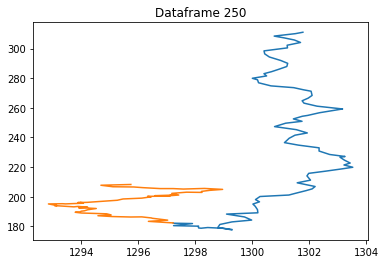

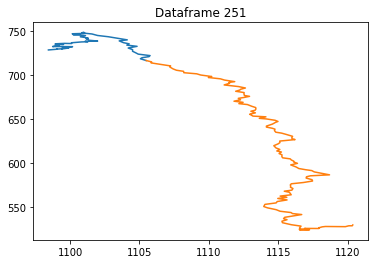

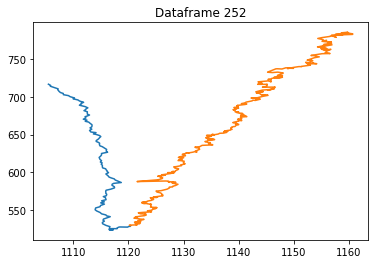

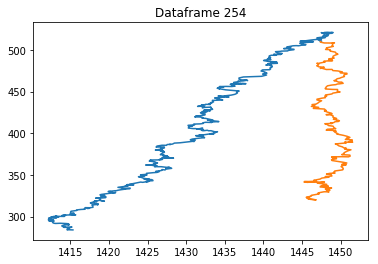

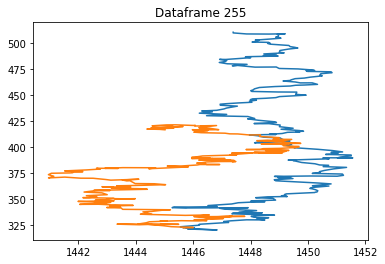

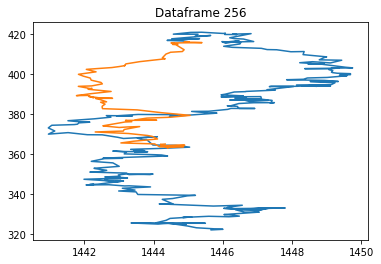

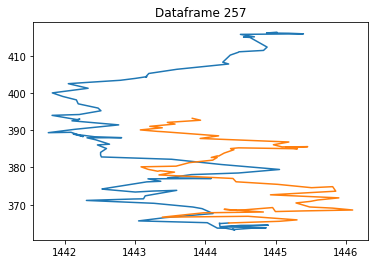

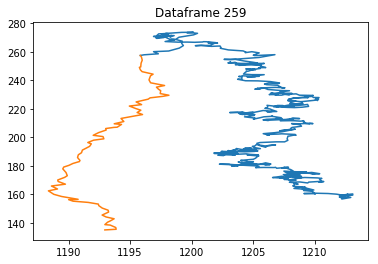

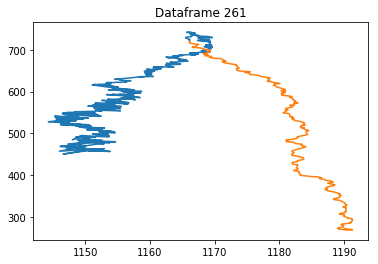

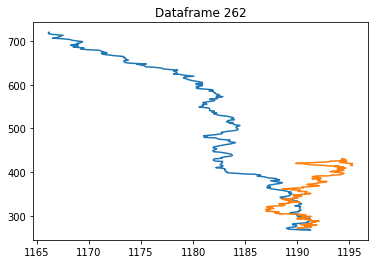

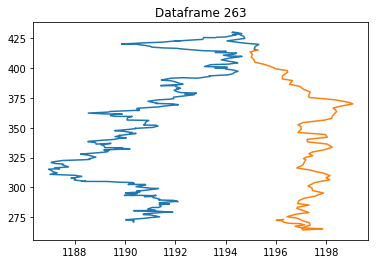

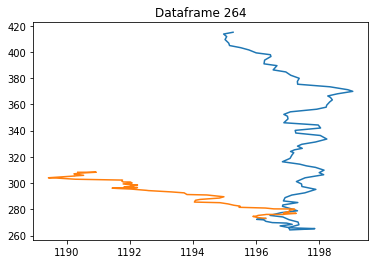

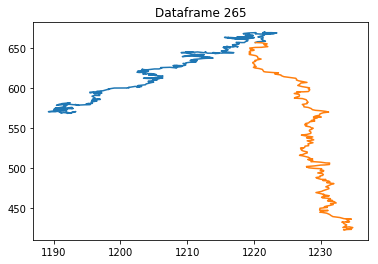

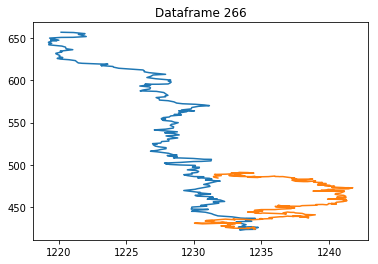

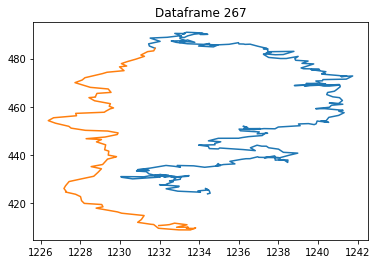

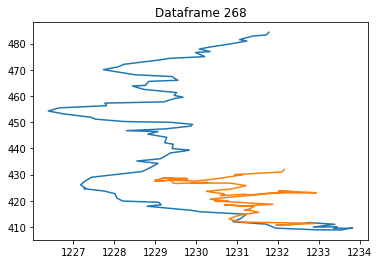

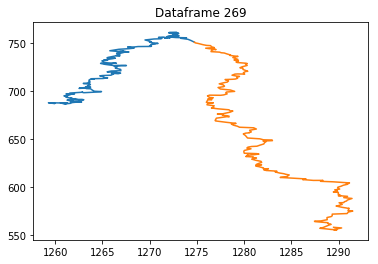

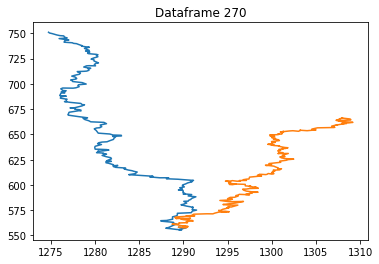

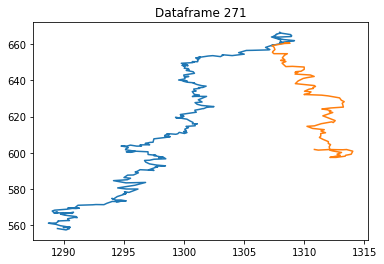

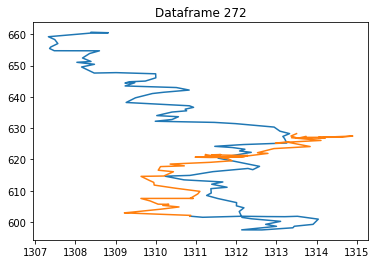

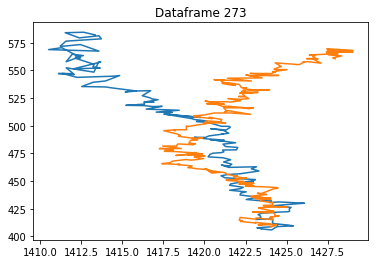

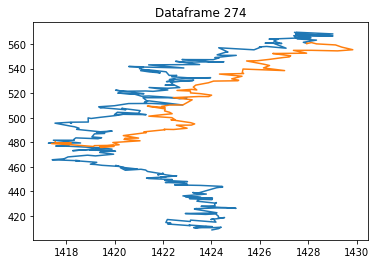

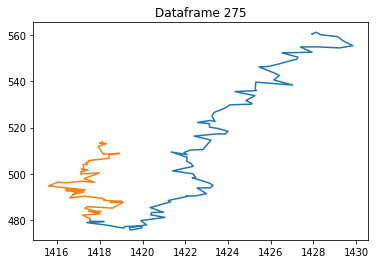

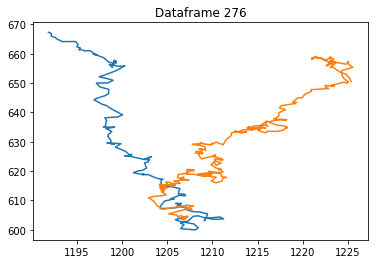

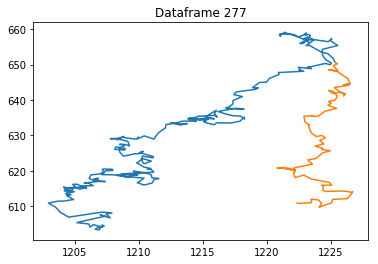

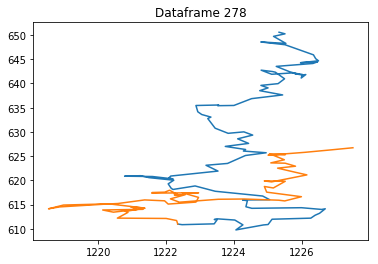

In [2]:
# Load in the dataframes of drop trajectories we've done.
all_dataframes = load_all_trajectories(os.getcwd())

charges = []
px_per_mm = ufloat(37, 2)*10
fps = 30

for i, tuple_df in enumerate(all_dataframes):
    # Skip this DF if it will be too short.
    if len(tuple_df[0]) <= 30 or len(tuple_df[1]) <= 30:
        continue

    # Plot everything designated as valid, for our own interest.
    if analyze_df(tuple_df[0], tuple_df[1], px_per_mm, fps)[0]:
        plt.figure()
        plt.title("Dataframe {}".format(i))
        plt.plot(tuple_df[0].x, tuple_df[0].y)
        plt.plot(tuple_df[1].x, tuple_df[1].y)
        plt.show()
    charges.append(analyze_df(tuple_df[0], tuple_df[1], px_per_mm, fps))

The radius of the oil drop is given as
$$
a = \sqrt{\left(\frac{b}{2p}\right)^2 + \frac{9\eta v_f}{2g\rho}} - \frac{b}{2p}
$$
where:

$$
\begin{align}
b &=  8.20 x 10^{-3} Pa · m\\
g &= 9.81 m/s\\
p &= \text{barometric pressure in pascals}\\
\rho &= \text{density of oil in } kg/m^3\\
v_f &= \text{velocity of fall in } m/s\\
v_r &= \text{velocity of fall in } m/s
\end{align}
$$

The mass is given by
$$
m = \frac{4\pi a^3 \rho}{3}
$$

and $q$ is given by
$$
q = \frac{mg(v_f + v_r)}{Ev_f}
$$
This is calculated in `analyze_df` using values for the falling and rising velocities that are implicitly contained in each `DataFrame`, as they all contain position and time information.

There is "bad" data; we have some particles that keep falling, even when the paralell-plate capacitor is turned on. This means they are either positively charged, or not charged at all. We can use these drops to determine how accurate our measurements are. We know that those are almost definitely supposed to be zero, so they're just showing us the magnitude of error. This is calculated internally by `miltools`, and we get flagged data in the form of `(boolean, ufloat)`

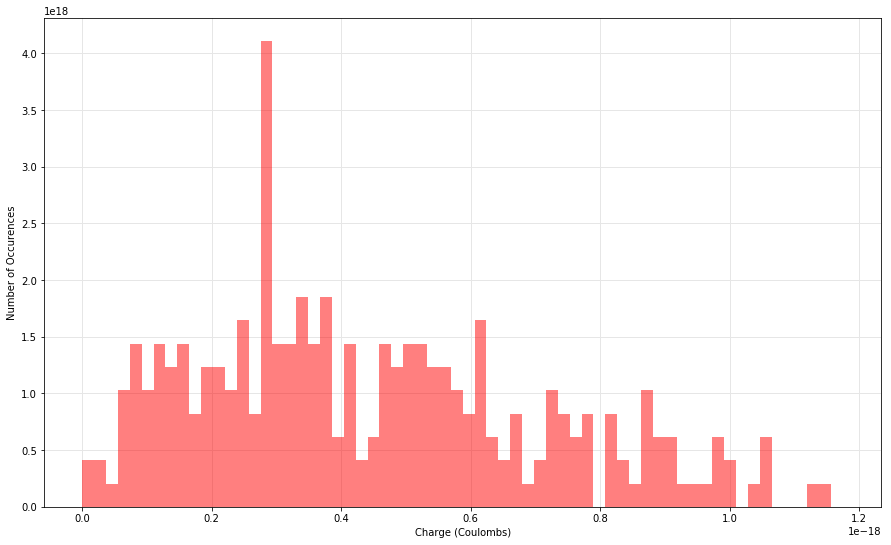

In [3]:
# Use our flagged data for error, and the rest of it for our graphs.
valid_particles = [abs(element[1].n) for element in charges if element[0]]
invalid_particles = [abs(element[1].n) for element in charges if not element[0]]

err = np.mean(invalid_particles)
bins = np.arange(0, 65*err, err)

# Now, put everything in a histogram. I'm going to norm it, because it's good to get a sense of the data
# in the form it will be in when we try to fit a distribution to it.
plt.figure(figsize=(15, 9))
plt.rc('axes', axisbelow=True)
plt.grid(color='0.9', linestyle='-', linewidth=1)

plt.hist(valid_particles, bins=bins, color='red', normed=True, alpha=0.5)

plt.xlabel('Charge (Coulombs)')
plt.ylabel('Number of Occurences')
plt.show()

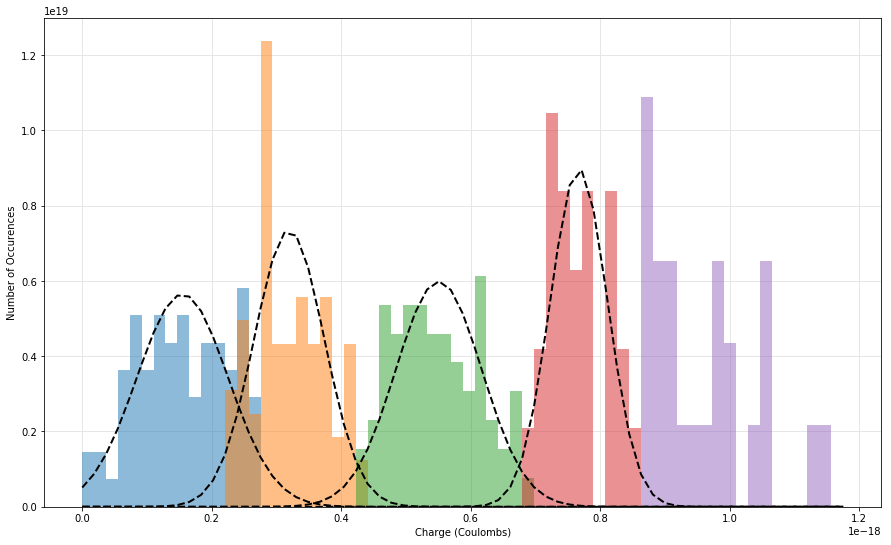

The resulting values for e: [1.548383490701299e-19+/-7.065560369323075e-20, 1.598417665195596e-19+/-2.714413206038712e-20, 1.8358171635483482e-19+/-2.2204333207577584e-20, 1.9176503732303476e-19+/-1.1099828118865329e-20]
Mean: (1.73+/-0.20)e-19
Experimental error is 7.670225094715072 %


In [5]:
# Draw a normed histogram with a few gaussian fits based on visual inspection.
group_1e = [element for element in valid_particles if element <= abs(15*err)]
group_2e = [element for element in valid_particles if 12*err < element <= 24*err]
group_3e = [element for element in valid_particles if 23*err < element <= 38*err]
group_4e = [element for element in valid_particles if 37*err < element <= 47*err]
group_5e = [element for element in valid_particles if 47*err < element]

plt.figure(figsize=(15, 9))
plt.rc('axes', axisbelow=True)
plt.grid(color='0.9', linestyle='-', linewidth=1)

# Plot each of the groups, with the associated Gaussian fit.
vals = []
for group in [group_1e, group_2e, group_3e, group_4e]:
    temp_n, temp_bins, temp_patches = plt.hist(group, bins=bins, normed=True, alpha=0.5)
    mean, std_dev = stats.norm.fit(group)
    y = mpl.mlab.normpdf(temp_bins, mean, std_dev)
    plt.plot(temp_bins, y, 'k--', linewidth=2)
    vals.append(ufloat(mean, std_dev))
    
# Although we don't see any gaussian behavior in the final section,
# graph it for completeness.
plt.hist(group_5e, bins=bins, normed=True, alpha=0.5)

plt.xlabel('Charge (Coulombs)')
plt.ylabel('Number of Occurences')
plt.show()

# Now that we've plotted everything, get a value for the charge.
all_res = [value/(position + 1) for position, value in enumerate(vals)]
implied_e = sum(all_res)/len(all_res)
exp_val = 1.60217662*10**-19
exp_err = (abs(implied_e.n - exp_val)/exp_val)*100

print("The resulting values for e:", all_res)
print("Mean:", implied_e)
print("Experimental error is", exp_err,"%")